Steps:
* Using TensorFlow Datasets to download and explore data
* Creating a preprocessing function for our data 
* Batching and preparing datasets for modelling (making them run fast)
* Setting up **mixed precision training** (for faster model training)
* Building and training a feature extraction model
* Fine-tuning the feature extraction model to beat the DeepFood paper
* Evaluating results on TensorBoard
* Evaluating results by making and plotting predictions


# Checking the GPU for Mixed Precision Training

Since we are dealing with such a huge training set, we can certainly benefit from speeding up the process by using Mixed Precision Training. Unfortunately, this requires having access to a GPU of Compute Capability `7.0` or higher and the only GPU that Colab gives access to is the Tesla T4 (that meets the requirement).  

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-1bb9b938-a494-c086-0265-e01e7a2689a0)


Okay we got lucky with the GPU.

# Data and Prep

We bring in the data for Food101 using TensorFlow datasets: the benefit with this is that we can skip some preprocessing steps since the data is **already in tensor format**.

Similarly we define some helper functions for later.

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import datetime

print(tf.__version__)

def create_tensorboard_callback(experiment, root_dir="food101models"):
  """Creates a TensorBoard callback instance to store log files"""
  log_dir = root_dir + "/" + experiment + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

def plot_loss_curves(history):
  """Plots the loss and accuracy curves for a given History object on seperate graphs"""
  # Get the information
  acc = history.history["accuracy"]
  loss = history.history["loss"]
  val_acc = history.history["val_accuracy"]
  val_loss = history.history["val_loss"]

  epochs = range(len(history.history["loss"]))

  # Plot the accuracy curves
  plt.figure()
  plt.plot(epochs, acc, label="Training Accuracy")
  plt.plot(epochs, val_acc, label="Validation Accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

  # Plot Loss curves
  plt.figure()
  plt.plot(epochs, loss, label="Training Loss")
  plt.plot(epochs, val_loss, label="Validation Loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()


def compare_historys(original_history, new_history, initial_epochs=3):
    """Compares two TensorFlow model History objects. Designed for Fine-tuning experiments."""
    
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

2.4.1


In [4]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

# Check if Food101 is inside the list of datasets
"food101" in tfds.list_builders()

True

In [5]:
# Now to load in the data (takes a while)
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # Data returned in tuple (data, label)
                                             with_info=True)

# Exploring the Data

Some standard procedures and things to find when exploring a new dataset:
* Find Input shapes
* Find class names
* Convert images to tensors (already done)
* The datatype of our input data
* What the labels look like (are they one-hot-encoded or label-encoded)

In [6]:
# Get features of Food101
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [7]:
# Get the class names and look at the first few
class_names = ds_info.features["label"].names
class_names[:12]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad']

In [8]:
# Take one sample of the train data
train_sample = train_data.take(1) # Samples are in format (tensor, label)
train_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [9]:
# Output info about our training sample
for image, label in train_sample:
  print(f"""
  Image Shape: {image.shape},
  Image datatype: {image.dtype},
  Target class from Food101 (tensor form): {label},
  Class name (string form): {class_names[label.numpy()]}
  """)


  Image Shape: (512, 512, 3),
  Image datatype: <dtype: 'uint8'>,
  Target class from Food101 (tensor form): 56,
  Class name (string form): huevos_rancheros
  


So we can see that the label in this dataset is *not* one-hot-encoded. This was important to find out since it determines what Loss Function we should use.

In [10]:
# Peek at the image tensor
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

In [11]:
# Find the range of the pixel values in the image tensor
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

Okay so the pixel values are in the range we expect: 0-255. 

Note that if we take a look at multiple images (running `take()` multiple times), we see that their shapes are *not* all the same which means we'd have to resize them. 

Their datatypes are integers which is a problem since we need to cast floats for the image tensor to optimize performance.

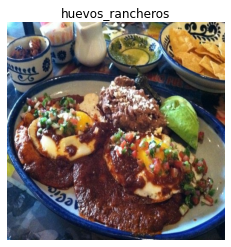

In [12]:
# Plot an image tensor and check if the given label is correct
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis(False);

# Preprocessing the Data

We have already extracted the data and split it thanks to TensorFlow Datasets. Now to work on preprocessing it before passing it to our Network.

Some facts:
* The values are all `uint8`- we'd like to cast as `float16` or `float32` since Neural Networks perform better off those
* The values are *not* scaled- we may have to normalize the values depending on which architecture we use
* The image tensors are all of different shapes- we need to resize them to a common shape

Let's write a preprocessing function to address these. We won't normalize the pixel values however, since we will use an `EfficientNetBX` model which already has rescaling built in.

In [13]:
# Make a preprocessing function
def preprocess_img(image, label, img_shape=224):
  """Converts image datatype from `uint8` to `float32` and reshapes image tensor to [img_shape, img_shape, color_channels]"""
  image = tf.image.resize(image, [img_shape, img_shape])
  # Return a tuple of image and label
  return tf.cast(image, tf.float32), label 

In [14]:
# Test out the function on the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}..., \nShape: {image.shape}, \nDatatype:{image.dtype}")
print()
print(f"Image after preprocessing:\n {preprocessed_img[:2]}..., \nShape: {preprocessed_img.shape}, \nDatatype:{preprocessed_img.dtype}")

Image before preprocessing:
 [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]..., 
Shape: (512, 512, 3), 
Datatype:<dtype: 'uint8'>

Image after preprocessing:
 [[[230.65816 253.64285 251.     ]
  [222.99998 254.97449 252.19388]
  [207.06633 255.      250.36734]
  ...
  [140.66287 129.52519 121.22428]
  [121.14268 115.26515 116.95397]
  [ 83.95363  83.08119  89.63737]]

 [[221.47449 254.37755 253.33163]
  [214.5102  255.      253.92348]
  [198.41327 254.58673 251.96939]
  ...
  [208.66318 195.82143 173.40823]
  [197.03056 190.1071  174.83162]
  [175.54036 171.6169  161.21384]]]..., 
Shape: (224, 224, 3), 
Datatype:<dtype: 'float32'>


Beautiful. Now the images have the same universal shape and the pixel values are cast as floats. 

Note that we did not normalize values since we'll use `EfficientNetBX`- if we wanted to do this inside the function, it would be as simple as `image = image / 255.`

## Batching and preparing our Datasets

Now we made a function to preprocess *one* image; we want this function to be applied to *all* images so all our data is ready for preprocessing.

TensorFlow has great documentation for **data input pipelines**: https://www.tensorflow.org/guide/data 

We will utilise some of the techniques mentioned in the documentation. We will
* Apply the function to all the images
* Turn our data into **batches**

In [15]:
# Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into Batches; also, prefetch it (runs faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In this step, we used `map` to map the function to all the training instances. It is important to note that the function we wrote also included and returned the `label`. This was done because the `train_data` we got from `tfds` returned both the image tensors **and** the labels. So we don't lose on any formatting here.

The second argument which specifies `AUTOTUNE` basically tells TensorFlow to have Colab use **all** the computational power it has.

In the second line of code, we `shuffle` the training data and set the number of samples we want to shuffle: ideally we'd set it to `len(train_data)` but with so many samples, we need to cut it small. After that we `batch` to form the mini-batches and call `prefetch` which is something that speeds the process up by having our kernel preprocess already loaded-in images on our CPU while the others are being operated on our GPU.

In [16]:
# Check the two sets
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

Perfect!

The images are of the proper size, and have the appropriate data types. Loading these two sets in is very fast, since we defined the parallelization strategy.

A summary of what we did:
* Map a preprocessing function to the training set
* Shuffled a number of elements across the training set 
* Enabled Prefetching and set up parallelization (multithreaded loading across all available CPUs)

# Modelling

Before we start creating our model, we need to instantiate some Callbacks.

This is because we have so many training instances, hence training can take a long time and we want to be able to do things like log performance on TensorBoard so we can view it later, etc.

We'll make use of
* the TensorBoard callback to visualize training results later if we want (already functionalized)
* `ModelCheckpoint` to save our model's performance after feature extraction

In [17]:
# Create the Checkpoint callback
checkpoint_path = "model_checkpoints/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_loss",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## Setup Mixed Precision Training

Again, this speeds up processes by using lower-bit precision for floats. It only works if we have enough Compute Capability on our GPU; if we want to use Colab, Tesla T4 is the only one that supports Mixed Precision Training that is offered by Google.

What's the logic for this speeding up by a possible **factor of 3**?

This just has the GPU (which can only fit a certain number of bits in it) convert `float32` to `float16` when it can so it can carry out even more processes at once.

In [18]:
# Turn on Mixed Precision training (only works with a compatible GPU)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") 

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


Now everything is set up.

# Build Feature Extraction Model

When setting up a model with Mixed Precision Training, we have to make one more change to our workflow: we specify the `dtype` of the Output Layer to be `float32` to preserve **numeric stability** (look at the docs mentioned above).

In [19]:
# Final check for Mixed Precision Training
mixed_precision.global_policy()

<Policy "mixed_float16">

In [20]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # Freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer", dtype=tf.float32)
# x = preprocessing.Rescaling(1./255)(x) <- Use this for models like ResNet that don't have Rescaling built in
x = base_model(inputs, training=False) # Set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x)  
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) # Specify dtype for numeric stability

model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16711680/16705208 [==============================] - 0s 0us/step


In [21]:
# Check the structure
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


So how do you check for Mixed Precision being used?

You can loop through each layer and check *which* `dtype_policy` is being used. The policy for each layer would be the same we specified earlier: `mixed_float16`.

In [22]:
# Check the dtype_policy for each layer
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


If you check the policy for each and every layer in the `EfficientNetB0` backbone, you will find the same mixed precision `dtype_policy`  for **all** the underlying layers. 

## Fitting the Feature Extraction Model

In [24]:
# Fit the feature extraction model for 3 epochs 
history_feature_extraction = model.fit(train_data,
                                       epochs=3,
                                       steps_per_epoch=len(train_data),
                                       validation_data=test_data,
                                       validation_steps=int(0.15*len(test_data)),
                                       callbacks=[create_tensorboard_callback(experiment="feature_extraction_model"),
                                                  model_checkpoint])

Saving TensorBoard log files to: food101models/feature_extraction_model20210628-075140
Epoch 1/3
2368/2368 [==============================] - 222s 78ms/step - loss: 2.3259 - accuracy: 0.4650 - val_loss: 1.2237 - val_accuracy: 0.6793
Epoch 2/3
2368/2368 [==============================] - 165s 69ms/step - loss: 1.3082 - accuracy: 0.6614 - val_loss: 1.1294 - val_accuracy: 0.6994
Epoch 3/3
2368/2368 [==============================] - 159s 66ms/step - loss: 1.1450 - accuracy: 0.7015 - val_loss: 1.0776 - val_accuracy: 0.7103


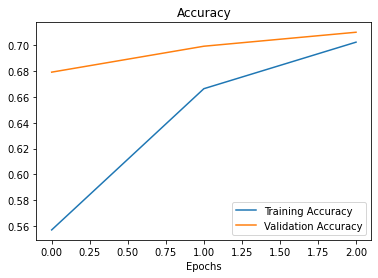

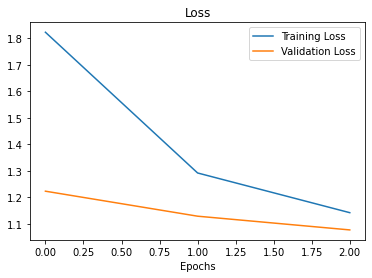

In [25]:
# Check the Loss curves
plot_loss_curves(history_feature_extraction)

Beautiful! The two loss curves decrease continously and the gap between them lessens which implies no Overfitting.

If you actually enabled Mixed Precision Training, you'd find that the time it takes to complete one epoch is just **three minutes**. And this is with **75000 training images** in total; that is FAST.

Our score to beat is around 76% which comes from the DeepFood paper. 

In [26]:
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 55s 69ms/step - loss: 1.0786 - accuracy: 0.7091


[1.0786052942276, 0.7091485261917114]

## Saving the Model

When fine-tuning our model, it will be helpful to have saved the Feature Extraction model so we can return/revert to it if we want to try different techniques.

Since this is a huge model, let's save it to Google Drive instead of Colab.

In [28]:
# Save model to Drive after mounting
import os
save_dir = "drive/MyDrive/models/food101/feature_extraction"
os.makedirs(save_dir) # Make this directory if it doesn't already exist

# Save model
model.save(save_dir)

INFO:tensorflow:Assets written to: drive/MyDrive/models/food101/feature_extraction/assets


INFO:tensorflow:Assets written to: drive/MyDrive/models/food101/feature_extraction/assets


In [ ]:
# Load the model we just saved
loaded_model = tf.keras.models.load_model(save_dir)

# Get evaluation metrics for loaded model to compare to the variable saved before
results_loaded = loaded_model.evaluate(test_data)

In [33]:
results_loaded, results_feature_extract_model # Should be very close

([1.0786046981811523, 0.7091485261917114],
 [1.0786052942276, 0.7091485261917114])

# Fine-tuning

Now to try and beat the score on the DeepFood paper. 

In [ ]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip

In [31]:
# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model

Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [ ]:
# Load and evaluate the downloaded model
downloaded_model = tf.keras.models.load_model("/content/downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision")
results_downloaded = downloaded_model.evaluate(test_data)

In [34]:
results_downloaded

[1.088122010231018, 0.7065742611885071]

In [35]:
# What does the downloaded model look like?
downloaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


We will make use of `EarlyStopping` to reduce the chances of Overfitting as best we can- specifically we will stop training if the Validation Loss does not improve for 3 epochs.  

`ReduceLROnPlateau` will also be helpful: it will automatically reduce the Learning Rate as the Loss approches the minimum value (we don't want it to continously make equally big jumps). 

We will also use the `ModelCheckpoint` callback to save the best model during fine-tuning so we can run experiments later if we desire.

In [36]:
# Setup EarlyStopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

# Setup ReduceLROnPlateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2,
                                                 patience=2,
                                                 min_lr=1e-7,
                                                 verbose=1)
# Create another ModelCheckpoint
checkpoint_path = "fine_tune_checkpoints/"
finetune_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_best_only=True,
                                                         monitor="val_loss")

In this Fine-tuning round, we will unfreeze **all** the layers in the base model. We do this because we have a **lot** of data and we can afford to do this step: if we had much less data, we would risk Overfitting if we unfroze too many layers in the pretrained model.

A final note on Fine-tuning: a good rule of thumb is to set the initial Learning Rate of our Optimizer around `10x` lower than the value used for training the Feature Extractor: the default for `Adam` is `0.001` so we shall use `0.0001`.

In [37]:
# Unfreeze all of the model layers (including the base model)
for layer in downloaded_model.layers:
  layer.trainable = True
  print(layer.name, layer.trainable)

# Find the number of trainable layers in the base model as a final check
count = 0
for layer in downloaded_model.layers[1].layers:
  count += int(layer.trainable)
print(f"Number of trainable layers in EfficientNetB0: {count}")

input_layer True
efficientnetb0 True
pooling_layer True
dense True
softmax_float32 True
Number of trainable layers in EfficientNetB0: 237


In [39]:
# Compile the model now
downloaded_model.compile(loss="sparse_categorical_crossentropy",
                         optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                         metrics=["accuracy"])

In [40]:
# Finetune the WHOLE model for 10 epochs since we don't care for Overfitting 
history_fine_tune = downloaded_model.fit(train_data,
                                         epochs=10,
                                         steps_per_epoch=len(train_data),
                                         validation_data=test_data,
                                         validation_steps=int(0.15 * len(test_data)),
                                         callbacks=[create_tensorboard_callback(experiment="finetuned_model"),
                                                    finetune_checkpoint,
                                                    early_stopping,
                                                    reduce_lr],
                                         verbose=1)

Saving TensorBoard log files to: food101models/finetuned_model20210628-081107
Epoch 1/10
2368/2368 [==============================] - 300s 121ms/step - loss: 0.9785 - accuracy: 0.7374 - val_loss: 0.8208 - val_accuracy: 0.7749
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


Epoch 2/10
2368/2368 [==============================] - 289s 120ms/step - loss: 0.5883 - accuracy: 0.8376 - val_loss: 0.7734 - val_accuracy: 0.7921
INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints/assets


Epoch 3/10
2368/2368 [==============================] - 285s 119ms/step - loss: 0.3328 - accuracy: 0.9053 - val_loss: 0.8609 - val_accuracy: 0.7812
Epoch 4/10
2368/2368 [==============================] - 288s 121ms/step - loss: 0.1632 - accuracy: 0.9530 - val_loss: 0.9795 - val_accuracy: 0.7775

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
Epoch 5/10
2368/2368 [==============================] - 286s 120ms/step - loss: 0.0493 - accuracy: 0.9882 - val_loss: 1.0564 - val_accuracy: 0.8016


In [42]:
# Evaluate on the full test set
results_finetuned = downloaded_model.evaluate(test_data)
results_finetuned

790/790 [==============================] - 54s 69ms/step - loss: 1.0677 - accuracy: 0.7952


[1.067657709121704, 0.795247495174408]

Amazing.

We beat the DeepFood paper with an accuracy of 79.5% on the Validation Set.

In [43]:
# Save model to Drive 
save_dir = "drive/MyDrive/models/food101/finetune"
os.makedirs(save_dir) # Make this directory if it doesn't already exist

# Save model
downloaded_model.save(save_dir)

INFO:tensorflow:Assets written to: drive/MyDrive/models/food101/finetune/assets


INFO:tensorflow:Assets written to: drive/MyDrive/models/food101/finetune/assets


In [44]:
# Get the summary for the final structure
downloaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
pooling_layer (GlobalAverage (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 101)               129381    
_________________________________________________________________
softmax_float32 (Activation) (None, 101)               0         
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
!tensorboard dev upload --logdir ./logs \
  --name "Food101 Models" \
  --description "Feature Extraction and Fine-tuned models with EfficientNetB0 backbone, trained on the full Food101 dataset." \
  --one_shot

# Evaluating

Now that we've formed a model to beat the DeepFood paper, let's visualize some predictions.

Some things to try out:
* Plot Loss curves
* A Classification Report to see the model performance on a class-by-class basis
* A graph to display the F1-scores of each class
* Plotting a random image and having the model make a prediction on it, then visualizing the full picture
* Finding the "most wrong" model predictions


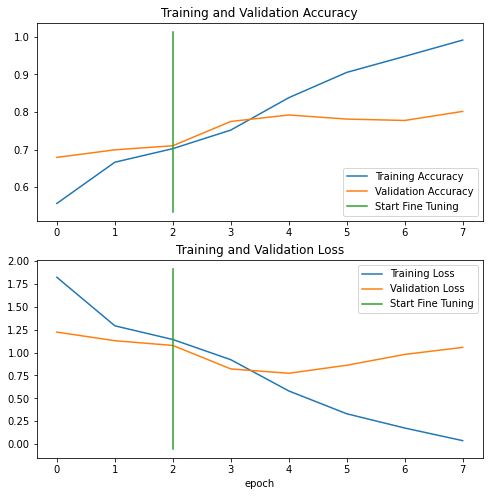

In [46]:
# Plot Loss curves across finetuning
compare_historys(history_feature_extraction, history_fine_tune)

So it seems that our fine-tuned model ended up Overfitting rather badly towards the end. Had we reduced the `patience` value in our `EarlyStopping` callback, our model would have generalized better to the Validation Set. 

Note that the model apparently reached 100% accuracy on the training set which is alarming.

In any case the callback did help with mitigating more damage to the model's weights.

In [73]:
# Redo loading in data since we must ensure files aren't shuffled this time
(train_data_N, test_data_N), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=False,
                                             as_supervised=True, # Data returned in tuple (data, label)
                                             with_info=True)
# Map preprocessing function to test data
test_data_N = test_data_N.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [77]:
# Make predictions with the model
pred_probs = downloaded_model.predict(test_data_N, verbose=1)

# Check the structure of the predictions predictions
print(f"Number of predictions: {len(pred_probs)}")
print(f"Shape of predictions: {pred_probs.shape}")
print(f"Number of prediction probabilities for sample 0: {len(pred_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {pred_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {pred_probs[0].argmax()}")

790/790 [==============================] - 50s 63ms/step
Number of predictions: 25250
Shape of predictions: (25250, 101)
Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [1.0380106e-04 2.3133502e-13 7.8141921e-10 8.7436453e-16 1.2957201e-10
 9.6841129e-12 7.0151480e-13 4.9461615e-12 2.5838128e-05 6.8960004e-10
 3.6492491e-08 9.4003039e-15 3.5020780e-09 1.3141451e-07 1.6873956e-07
 1.4559477e-14 1.6203115e-04 8.9294181e-06 3.2859713e-17 3.8683057e-10
 5.8245231e-16 1.4493875e-05 1.1003202e-06 6.5427428e-09 3.2810285e-14
 1.1632256e-13 1.3734993e-12 1.7962235e-07 2.0268471e-09 9.9884135e-01
 4.1115962e-07 4.7324181e-07 8.5590740e-15 1.9539098e-19 2.4411672e-06
 2.3301023e-17 1.0133599e-08 2.5407183e-13 2.5846165e-16 3.0646915e-13
 2.8064126e-14 4.8286993e-16 1.8717077e-06 2.3071138e-18 3.7549383e-13
 3.5872687e-05 9.4003039e-15 2.5846165e-16 2.4485275e-12 4.1826356e-10
 3.3659051e-13 4.9254071e-14 7.3209642e-15 2.4833449e-09 2.2140699

In [78]:
# Get the class predictions of each label
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10], pred_classes.shape

(array([ 29,  81,  91,  53,  97,  97,  10,  31,   3, 100]), (25250,))

In [81]:
# Get the labels now that we have the predicted classes
y_labels = []
for images, labels in test_data_N.unbatch():
  y_labels.append(labels.numpy())
y_labels[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [82]:
# Check if the shapes are compatible
print(f"Shape of pred_classes: {pred_classes.shape}")
print(f"Length of y_labels: {len(y_labels)}")

Shape of pred_classes: (25250,)
Length of y_labels: 25250


In [83]:
# Make a classification report
from sklearn.metrics import classification_report
print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.64      0.58      0.61       250
           1       0.75      0.78      0.77       250
           2       0.82      0.88      0.85       250
           3       0.82      0.83      0.82       250
           4       0.71      0.74      0.73       250
           5       0.68      0.70      0.69       250
           6       0.81      0.89      0.85       250
           7       0.88      0.91      0.89       250
           8       0.60      0.61      0.60       250
           9       0.83      0.70      0.76       250
          10       0.70      0.77      0.73       250
          11       0.86      0.83      0.85       250
          12       0.88      0.84      0.86       250
          13       0.78      0.77      0.78       250
          14       0.73      0.78      0.75       250
          15       0.71      0.60      0.65       250
          16       0.58      0.72      0.64       250
          17       0.84    

In [84]:
# Now to construct a plot of the F1-scores for each class
cr_dict = classification_report(y_labels, pred_classes, output_dict=True)

# Prepare dictionary for holding F1-scores
f1_scores = {}
for k,v in cr_dict.items():
  if k == "accuracy": # Reached the end of the F1-scores
    break
  else:
    f1_scores[class_names[int(k)]] = v["f1-score"]

# Make a DataFrame
import pandas as pd
f1_df = pd.DataFrame({
    "class_name": list(f1_scores.keys()),
    "f1-score": list(f1_scores.values())
}).sort_values("f1-score", ascending=False)

f1_df

,class_name,f1-score
33,edamame,0.983936
63,macarons,0.941650
75,pho,0.927022
91,spaghetti_carbonara,0.924000
69,oysters,0.920949
...,...,...
22,chocolate_mousse,0.608534
0,apple_pie,0.606316
8,bread_pudding,0.603550
39,foie_gras,0.597403


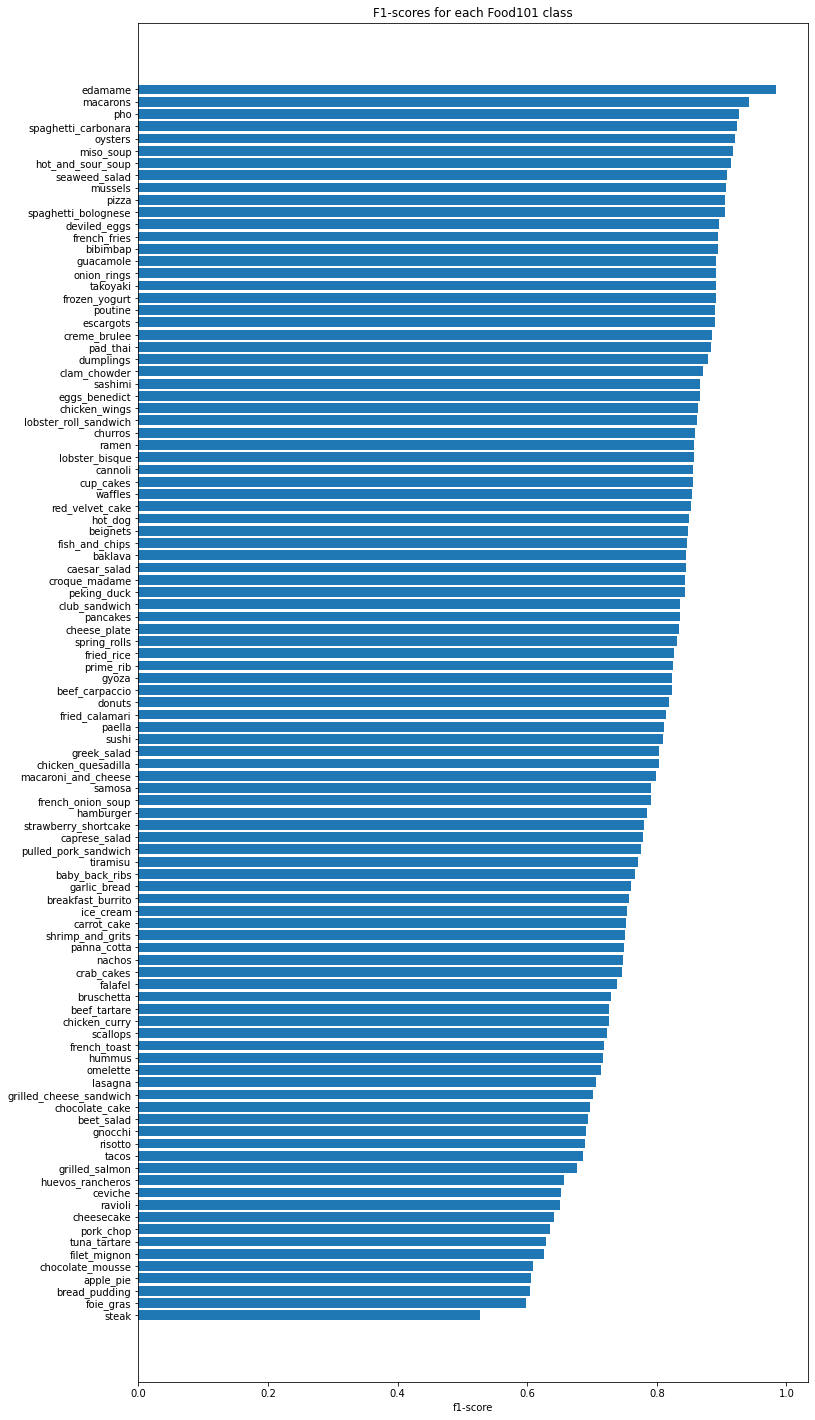

In [85]:
# Make a Horizontal Bar chart with it
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,25))
scores = ax.barh(range(len(f1_df)), f1_df["f1-score"].values)
ax.set_yticks(range(len(f1_df)))
ax.set_yticklabels(list(f1_df["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-scores for each Food101 class")
ax.invert_yaxis()

## Predicting on Custom Images

Now to take images right from Google Drive and see how our model performs on it.

In [88]:
# Get the paths
import os

custom_food_images = ["/content/drive/MyDrive/FoodVisionCustomImages/" + img_path for img_path in os.listdir("/content/drive/MyDrive/FoodVisionCustomImages")]
custom_food_images

['/content/drive/MyDrive/FoodVisionCustomImages/edamame.jpg',
 '/content/drive/MyDrive/FoodVisionCustomImages/macarons.jpg',
 '/content/drive/MyDrive/FoodVisionCustomImages/pizza.jpg']

In [92]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads in an image from filename, turns it into a tensor and reshapes into
  (224, 224, 3).
  Parameters
  ----------
  filename (str): string filename of target image
  img_shape (int): size to resize target image to, default 224
  scale (bool): whether to scale pixel values to range(0, 1), default True
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.image.decode_jpeg(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

def pred_plot_custom(custom_images=custom_food_images):
  """Plots three images with the top 5 likely predictions"""
  i=0
  fig,a =  plt.subplots(len(custom_food_images),2, figsize=(15, 5*len(custom_food_images)))

  for img in custom_food_images:
    img = load_and_prep_image(img, scale=False) 
    pred_prob = model.predict(tf.expand_dims(img, axis=0)) 
    pred_class = class_names[pred_prob.argmax()]
    top_5_i = (pred_prob.argsort())[0][-5:][::-1]
    values = pred_prob[0][top_5_i] 
    labels = []
    for x in range(5):
      labels.append(class_names[top_5_i[x]])

    # Plotting Image
    a[i][0].imshow(img/255.) 
    a[i][0].set_title(f"Prediction: {pred_class}   Probability: {pred_prob.max():.2f}")
    a[i][0].axis(False)

    # Plotting Models Top 5 Predictions
    a[i][1].bar(labels, values, color='orange');
    a[i][1].set_title('Top 5 Predictions')
    i=i+1

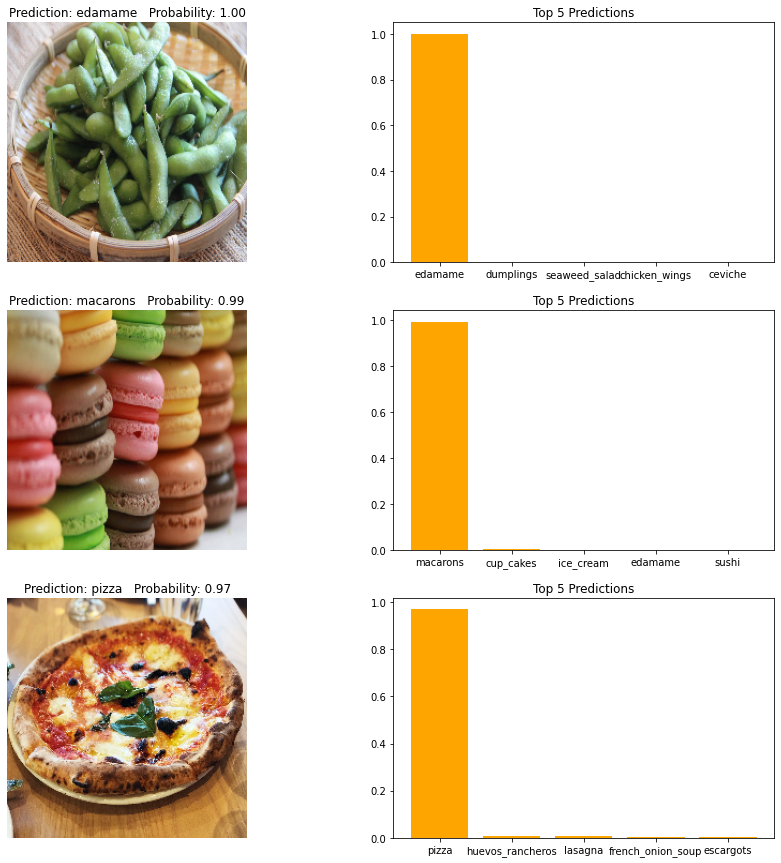

In [93]:
pred_plot_custom()

Beautiful!

# FIN